In [147]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import factorial2



In [148]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   #imp vol estimator based on P Jäckel Let's be rational

In [149]:
def gaussian_moment(p, sigma):
    if p % 2 == 1:
        return 0
    else:
        return (sigma ** p) * math.prod(range(1, p, 2))  # (p - 1)!!

In [150]:
def alpha_convolution(alpha,k):
    result = 0
    for j in range(k + 1):
        if j < len(alpha) and (k - j) < len(alpha):
            result += alpha[j] * alpha[k - j]
    return result


In [151]:
def binom(k, i):
    return math.comb(k, i) if 0 <= i <= k else 0

Dans les modèles de volatilité rugueuse, le processus $X_t$ est souvent défini comme une approximation d'un noyau fractionnaire par un noyau exponentiel. On considère alors l'équation différentielle stochastique suivante :

$$
dX_t = -\frac{1/2 - H}{\varepsilon} X_t\, dt + \varepsilon^{H - \frac{1}{2}}\, dW_t
$$

où :

- $H \leq 0.5$ est le paramètre de Hurst qui contrôle la rugosité du processus.
- $\varepsilon > 0$ est un paramètre d'échelle qui permet d'approcher le noyau fractionnaire par un noyau exponentiel.
- $W_t$ est un mouvement brownien standard.

Ce processus est une version de l'Ornstein–Uhlenbeck, avec :

$$
\kappa = \frac{1/2 - H}{\varepsilon}, \quad \sigma = \varepsilon^{H - \frac{1}{2}}
$$

et peut être écrit de manière plus compacte comme :

$$
dX_t = -\kappa X_t\, dt + \sigma\, dW_t
$$
$$
X_t \sim \mathcal{N}\left( X_0 e^{-\kappa t},\ \frac{\sigma^2}{2\kappa} \left(1 - e^{-2\kappa t} \right) \right)
$$
La variance de $X_t$ est donnée par :

$$
\text{Var}(X_t) = \frac{\sigma^2}{2\kappa} \left(1 - e^{-2\kappa t} \right)
\newline
X_t \sim \mathcal{N}\left( X_0 e^{-\frac{1/2 - H}{\varepsilon} t},\ \frac{\varepsilon^{2H - 1}}{2(1/2 - H)} \left(1 - e^{-2\frac{1/2 - H}{\varepsilon} t} \right) \right)
\newline 
X_{t+h} = e^{-\kappa h}X_t+\sqrt{\frac{\sigma ^2}{2\kappa}(1-e^{-2\kappa h})}Z[k]

$$



In [152]:
def simulate_OU_X(T, n_steps, eps=1/52, H=0.1, N_sims=10000):
    """
    Simulates paths of the Ornstein-Uhlenbeck (OU) process and stores the trajectories and noise.

    Args:
        T (float): Total time duration for the simulation (e.g., 1 year).
        n_steps (int): Number of time steps in the simulation.
        eps (float, optional): Time scaling parameter (default is 1/52, assuming weekly steps).
        H (float, optional): Hurst parameter (default is 0.1).
        N_sims (int, optional): Number of simulation paths (default is 10000).

    Returns:
        Y_storage (ndarray): Array of shape (N_sims, n_steps) containing the standard normal random variables used as noise at each time step.
        trajectories (ndarray): Array of shape (N_sims, n_steps) containing the simulated Ornstein-Uhlenbeck process trajectories, scaled by the rough volatility term.
    """

    dt = T / n_steps
    X = np.zeros((N_sims, n_steps))
    X[:, 0] = np.random.normal(loc=1, scale=np.sqrt(2), size=N_sims)

    trajectories = np.zeros((N_sims, n_steps))
    Y_storage = np.zeros((N_sims, n_steps))
    
    kappa = (0.5 - H) / eps
    beta = np.sqrt(eps**(2 * H) / (1 - 2 * H))

    for i in range(1, n_steps):
        Z = np.random.randn(N_sims)  # N(0,1) noise
        dX = beta * (np.exp(kappa * i * dt / 2) - np.exp(kappa * (i - 1) * dt)) * Z
        X[:, i] = X[:, i - 1] + dX

        alpha = np.exp((0.5 - H) * (-i * dt) / eps)
        trajectories[:, i] = alpha * X[:, i]
        Y_storage[:, i] = Z

    return Y_storage, trajectories



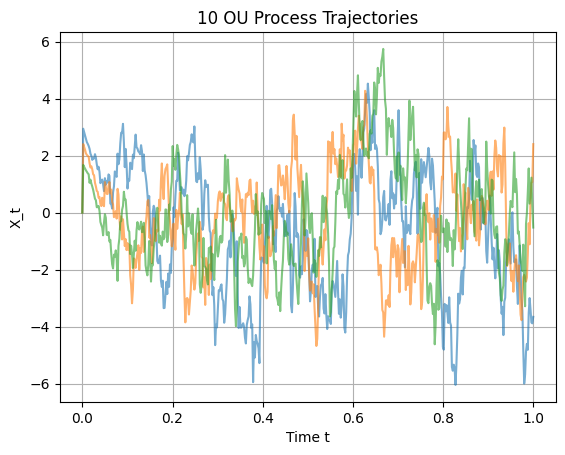

In [153]:
_, X = simulate_OU_X(T=1.0, n_steps=500, N_sims=10)
t = np.linspace(0, 1.0, 500)

for i in range(3):
    plt.plot(t, X[i], alpha=0.6)

plt.title("10 OU Process Trajectories")
plt.xlabel("Time t")

plt.ylabel("X_t")
plt.grid(True)
plt.show()


In [154]:
def gaussian_moment_GT(eps, H, T, u, power):
    """Compute E[(G_T^u)^power] where G_T^u ~ N(0, σ^2)"""
    delta = u - T
    if delta <= 0:
        return 0  # undefined if u < T
    if power % 2 == 1:
        return 0
    # Compute σ^2
    sigma2 = eps**(2 * H) * (1 - math.exp(-(1 - 2 * H) * eps**-1 * delta)) / (1 - 2 * H)
    sigma = math.sqrt(sigma2)
    # Compute even moment: σ^power * (power - 1)!!
    return gaussian_moment(power, sigma)


In [155]:
X = np.array((1,5,2))
print(X**2)

[ 1 25  4]


In [156]:
def compute_VIX_squared(X_T, beta, Delta):
    """
    Compute VIX_T^2 = (100^2 / Delta) * sum_{i=0}^{10} β_i * X_T^i
    """
    vix2 = sum(beta[i] * (X_T ** i) for i in range(len(beta)))
    return (100**2 / Delta) * vix2

def compute_VIX(X_T, beta, Delta):
    """
    Compute VIX_T = sqrt(VIX_T^2)
    """
    vix_squared = compute_VIX_squared(X_T, beta, Delta)
    return math.sqrt(vix_squared)


In [157]:
arr = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
print(arr.shape)
N,n = arr.shape
print(N,n)

(2, 4)
2 4


In [158]:
def simulate_log_SW(Y_trajectory, sigma_path, rho, T, log_S0):
    """
    Simulate the path of log(S^W_t) using the discretized SDE:
    log(S_{i+1}) = log(S_i) - 0.5 * (rho * sigma_i)^2 * dt + rho * sigma_i * sqrt(dt) * Y_i

    Args:
        Y_trajcetory: Y_trajectory
        sigma_path: array of sigma_t values at each t
        rho: correlation parameter
        log_S0: initial log price
        seed: random seed

    Returns:
        log_S: array of simulated log(S^W_t) values
    """
    N_sims, n_steps = sigma_path.shape
    dt = T/n_steps
    log_S = np.zeros(N_sims, n_steps)
    log_S[:,] = log_S0

    for i in range(N):
        sigma_i = sigma_path[:, i]
        drift = -0.5 * (rho * sigma_i)**2 * dt
        diffusion = rho * sigma_i * np.sqrt(dt) * Y_trajectory[:, i]
        log_S[i+1] = log_S[i] + drift + diffusion

    return log_S


0.02
0.02
[0.02 0.02]


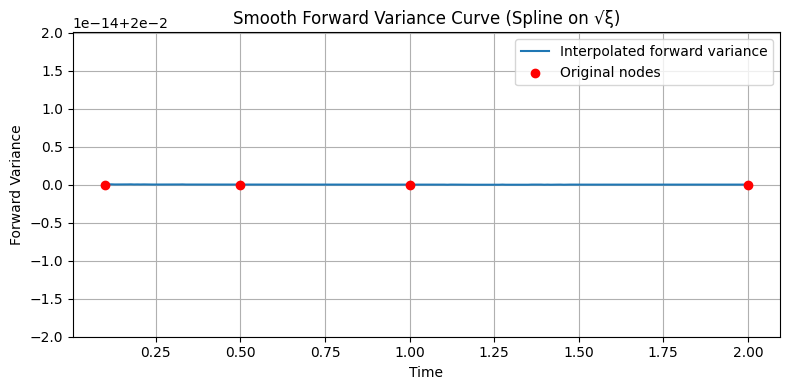

In [159]:
def make_fv_curve_interpolator(T_array_nodes, fv_nodes, spline_order=3):
    """
    Returns a function that computes the forward variance curve at any time t.

    Parameters:
    -----------
    T_array_nodes : array-like
        Time nodes at which forward variance values are provided.
    fv_nodes : array-like
        Forward variance values at the nodes.
    spline_order : int
        Order of the spline (default is 3 for cubic).

    Returns:
    --------
    fv_curve(t) : function
        A function that returns the interpolated forward variance at time t.
        Returns a scalar if t is scalar, array if t is array.
    """
    spline_sqrt = interpolate.splrep(T_array_nodes, np.sqrt(fv_nodes), k=spline_order)

    def fv_curve(t):
        t = np.asarray(t)
        sqrt_interp = interpolate.splev(t, spline_sqrt, der=0)
        squared = np.square(sqrt_interp)
        return float(squared) if np.isscalar(t) or t.shape == () else squared

    return fv_curve

# Example usage
T_array_nodes = np.array([0.1, 0.5, 1.0, 2.0])
fv_nodes = np.array([0.02, 0.02, 0.02, 0.02])
fv = make_fv_curve_interpolator(T_array_nodes, fv_nodes)

print(fv(1.5))  # scalar input → scalar output
print(fv(np.array(1.5)))  # scalar wrapped in array → still scalar
print(fv(np.array([1.5, 1.8])))  # vector input → array output

# Plotting
t_plot = np.linspace(min(T_array_nodes), max(T_array_nodes), 200)
fv_plot = fv(t_plot)

plt.figure(figsize=(8, 4))
plt.plot(t_plot, fv_plot, label="Interpolated forward variance")
plt.scatter(T_array_nodes, fv_nodes, color='red', zorder=5, label="Original nodes")
plt.title("Smooth Forward Variance Curve (Spline on √ξ)")
plt.xlabel("Time")
plt.ylabel("Forward Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [160]:
def horner_vector(poly, x):
    """
    Evaluate a polynomial at multiple values using Horner's method.

    Args:
        poly (array-like): Coefficients of the polynomial a_0, a_1, ..., a_d, where poly[0] is the coefficient of the highest degree term.
        x (ndarray): Array of shape (N_sims, n_steps), values at which to evaluate the polynomial.

    Returns:
        ndarray: Array of shape (N_sims, n_steps), values of the polynomial at each x.
    """
    N_sims, n_steps = x.shape
    result = np.zeros((N_sims, n_steps))  # Fixing the shape of result array to (N_sims, n_steps)

    # Start with the highest degree term (first coefficient)
    result = poly[0] * np.ones((N_sims, n_steps))

    # Apply Horner's method
    for coeff in poly[1:]:
        result = result * x + coeff

    return result


$$X_t \sim \mathcal{N}\left( X_0 e^{-\frac{1/2 - H}{\varepsilon} t},\ \frac{\varepsilon^{2H - 1}}{2(1/2 - H)} \left(1 - e^{-2\frac{1/2 - H}{\varepsilon} t} \right) \right)
$$

In [161]:
def factorial2(n):
    """ Returns the double factorial (2n-1)!! """
    if n <= 0:
        return 1
    return n * factorial2(n-2)

def expected_fx_squared(a_k, eps=1/52, H=0.1, T=12, n_steps=1000):
    """
    Computes E[f(X)^2] where f(X) = a_0 + a_1 X + ... + a_d X^d,
    and X ~ N(0, std_X^2), using analytic Gaussian moments.

    Args:
        a_k: array of polynomial coefficients [a0, a1, ..., ad]
        eps: small epsilon value
        H: roughness parameter
        T: time horizon
        n_steps: number of time steps

    Returns:
        var_f: array of shape (n_steps,) with expected values E[f(X_t)^2]
    """
    # Step 1: Compute the coefficients for f(x)^2 = (sum a_k x^k)^2
    c_k = np.convolve(a_k, a_k)  # Coefficients of f(x)^2
    print(f"c_k: {c_k}")  # Debugging: Check the coefficients

    sigma_2 = eps**(2 * H - 1)  # Sigma squared for the volatility process
    kappa = (0.5 - H) / eps  # Kappa term for volatility
    dt = T / n_steps  # Time step size
    print(f"sigma_2: {sigma_2}, kappa: {kappa}")  # Debugging: Check sigma_2 and kappa
    
    # Compute variance of X_t over time
    var_X = np.array([sigma_2 * (1 - np.exp(-2 * kappa * (i * dt))) / (2 * kappa) for i in range(n_steps + 1)])
    print(f"var_X: {(max(var_X))}")  # Debugging: Check the variance values
    print(f"var_X: {(np.argmin(var_X))}")  # Debugging: Check the variance values
    var_X+=1e-8
    var_f = np.zeros(n_steps)
    
    # Step 2: Compute the expected value of f(X)^2 for each time step
    for i in range(n_steps):
        std = np.sqrt(var_X[i])  # Standard deviation at step i
        if std < 0:  # Check if standard deviation is negative (which should not happen)
            print(f"Invalid std at i={i}, std={std}")
            continue
        
        # Sum over the polynomial terms
        for k in range(len(c_k)):
            if k % 2 == 1:  # Skip odd powers for now (this can be adjusted depending on the problem)
                continue
            try:
                var_f[i] += c_k[k] * factorial2(k) * std**k
            except OverflowError:
                print(f"Overflow error at i={i}, k={k}")
                continue
    
    return var_f  # Expected variance of f(X)

# Example usage
a_k = np.array([0.01, 0.01, 0, 0.01, 0, 0.05])  # Polynomial coefficients
var_f = expected_fx_squared(a_k)


c_k: [0.0001 0.0002 0.0001 0.0002 0.0002 0.001  0.0011 0.     0.001  0.
 0.0025]
sigma_2: 23.594059750594578, kappa: 20.8
var_X: 0.5671648978508312
var_X: 0


In [162]:
X = np.array([(1,2,3)])
Y =  X*X
print(Y)
print(np.mean(Y))
a_k = np.array([1,0])
f = horner_vector(a_k,X)
print(f)

[[1 4 9]]
4.666666666666667
[[1. 2. 3.]]


$$X_t \sim \mathcal{N}\left( X_0 e^{-\frac{1/2 - H}{\varepsilon} t},\ \frac{\varepsilon^{2H - 1}}{2(1/2 - H)} \left(1 - e^{-2\frac{1/2 - H}{\varepsilon} t} \right) \right)
$$

In [163]:
def sigma(ksi_0, X, a_k, eps, H, T, n_steps, N_sims):
    """
    Compute sigma_t for multiple paths of X_t.

    Args:
        ksi_0: function t ↦ ksi_0(t)
        X: array of shape (N_sims, n_steps) – simulated values of X_t
        a_k: array of polynomial coefficients a_k = [a0, a1, ..., ad]
        eps, H: rough volatility parameters
        T: maturity
        n_steps: number of time steps
        N_sims: number of simulations

    Returns:
        sigma_t: array of shape (n_steps, N_sims)
    """
    # Time grid for t in [0, T]
    # Compute E[f(X)^2] analytically for each std_X using the pre-defined function
    #var_f = expected_fx_squared(a_k, eps=eps, H=H, T=T, n_steps=n_steps)
    #print(f"Number of values in var_f < 1e-4: {np.sum(var_f < 1e-4)}")
    
    # Prevent division by zero or very small values by adding a small constant
    #var_f += 1e-8  # Small constant to avoid division by zero

    # Evaluate f(X_t) for each path using Horner's method
    a0,a1,a2,a3,a4,a5=a_k[0],a_k[1],0,a_k[3],0,a_k[5]
    f_X = a0+a1*X+a3*X**3+a5*X**5
    print(f_X.shape)
    # Evaluate ksi_0(t) at each time step
    dt = T/n_steps
    # Compute the final sigma_t
    sigma_t = np.zeros((N_sims, n_steps))
    L = [np.mean(f_X[:,i]**2) for i in range(5,n_steps)]
    var = min(L)
    print("min var is ", var)
    for i in range(n_steps):
        #sigma_t[:,i] = np.sqrt(ksi_0(dt*i))*f_X[:,i]/np.sqrt(var_f[i])
        sigma_t[:,i] = np.sqrt(ksi_0(dt*i))*f_X[:,i]/np.sqrt(np.mean(f_X[:,i]*f_X[:,i])+1e-2)
    return sigma_t  # Shape: (n_steps, N_sims)



In [164]:
def simulate_logS_batched(S0, sigma_t, rho, dt,Y_trajectory):
    """
    Simulate log(S_t) using only the correlated part of the Brownian motion,
    for multiple Monte Carlo paths.

    Args:
        S0: initial price (scalar)
        sigma_t: (N_sims, n_step) array of volatility values σ_t
        rho: correlation coefficient
        dt: time step size (scalar)
        seed: random seed (optional)

    Returns:
        log_S: array of shape (N_sims, n_steps) containing log(S_t) paths
    """
    N_sims, n_steps = sigma_t.shape
    log_S = np.zeros((N_sims, n_steps))
    log_S[0, :] = np.full(n_steps, np.log(S0))

    # Generate standard normal shocks for each (step, path)

    for i in range(1, n_steps):
        sigma_prev = sigma_t[:,i - 1]  # shape: (n_sims,)
        drift = -0.5 * (rho * sigma_prev)**2 * dt
        diffusion = rho * sigma_prev * np.sqrt(dt) * Y_trajectory[:, i - 1]
        log_S[:, i] = log_S[:, i-1] + drift + diffusion

    return log_S


5.233591338082988e-13
fv(0.1) = 1.0000000000000009
(1000, 5000)
min var is  0.00045782503878858484
log S is  [ 4.60517019  4.60516946  4.58774967 ... 76.53930213 76.54105369
 76.54091228]
sigma 0 is  [ 0.0099995   0.13014857  0.12965888 ... -0.01251579 -0.0051475
 -0.00052955]


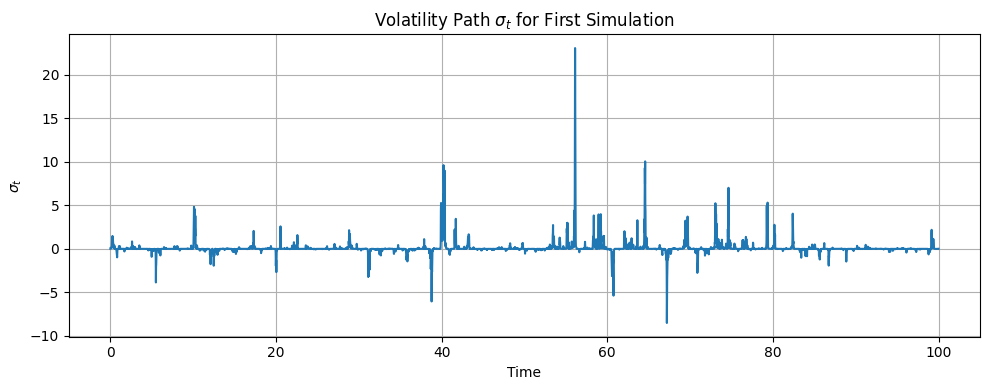

In [165]:
eps = 0.2
H =  -0.1382
a_k = [0.001, 0.0001, 0, 0.001,0, 0.001]
T =  100
n_steps = 5000
N_sims = 1000
S0 = 100
rho = -0.85
dt = T / n_steps

# Forward variance curve nodes
T_array_nodes = np.array([-1000, 0.5, 1.0, 1000])
fv_nodes = np.array([1, 1, 1, 1])

# Build interpolator
fv = make_fv_curve_interpolator(T_array_nodes, fv_nodes)
print(fv(5)-fv(500))
# Simulate OU process
Y_trajectory, X = simulate_OU_X(T=T, n_steps=n_steps, eps=eps, H=H, N_sims=N_sims)

# Debug: evaluate one point
print(f"fv(0.1) = {fv(0.1)}")

# Compute sigma_t
sigma_t = sigma(fv, X, a_k, eps, H, T, n_steps, N_sims)

# Simulate log-price
log_S = simulate_logS_batched(S0, sigma_t, rho, dt, Y_trajectory)
log_S = log_S[0, :]
print("log S is ", log_S)

# Extract and print first volatility path
sigma_0 = sigma_t[0, :]
print("sigma 0 is ", sigma_0)

# Plot sigma_0
t_grid = np.linspace(0, T, n_steps)
plt.figure(figsize=(10, 4))
plt.plot(t_grid, sigma_0)
plt.title(r"Volatility Path $\sigma_t$ for First Simulation")
plt.xlabel("Time")
plt.ylabel(r"$\sigma_t$")
plt.grid(True)
plt.tight_layout()
plt.show()


In [166]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
import numpy as np

def vec_find_vol_rat(call_prices, S0, strike_array, T, flag, r=0.0):
    """
    Vectorized implied volatility calculation using py_vollib.
    """
    iv_func = np.vectorize(lambda price, K: implied_volatility(price, S0, K, T, r, flag))
    return iv_func(call_prices, strike_array)


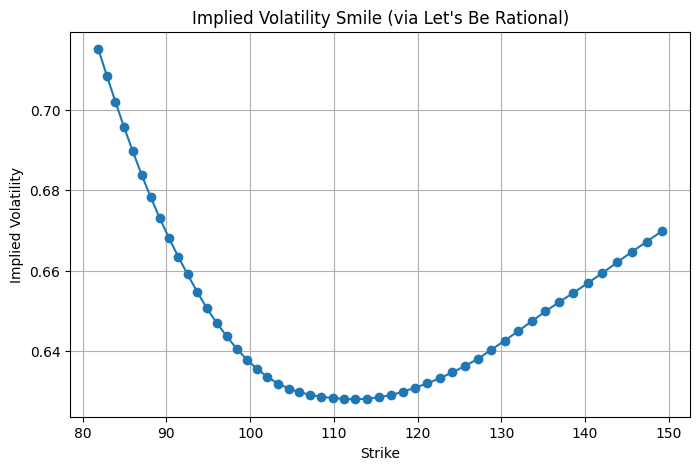

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from py_vollib.black_scholes.implied_volatility import implied_volatility

# 1. Forward variance curve interpolator
def make_fv_curve_interpolator(T_array_nodes, fv_nodes, spline_order=3):
    spline_sqrt = splrep(T_array_nodes, np.sqrt(fv_nodes), k=spline_order)
    def fv(t):
        t = np.asarray(t)
        sqrt_interp = splev(t, spline_sqrt, der=0)
        return np.square(sqrt_interp)
    return fv

# 2. Simulate OU process
def simulate_OU_X(T, n_steps, eps=1/52, H=0.1, N_sims=10000):
    """
    Simulates paths of the Ornstein-Uhlenbeck (OU) process and stores the trajectories and noise.

    Args:
        T (float): Total time duration for the simulation (e.g., 1 year).
        n_steps (int): Number of time steps in the simulation.
        eps (float, optional): Time scaling parameter (default is 1/52, assuming weekly steps).
        H (float, optional): Hurst parameter (default is 0.1).
        N_sims (int, optional): Number of simulation paths (default is 10000).

    Returns:
        Y_storage (ndarray): Array of shape (N_sims, n_steps) containing the standard normal random variables used as noise at each time step.
        trajectories (ndarray): Array of shape (N_sims, n_steps) containing the simulated Ornstein-Uhlenbeck process trajectories, scaled by the rough volatility term.
    """

    dt = T / n_steps
    X = np.zeros((N_sims, n_steps))
    X[:, 0] = np.random.normal(loc=1, scale=np.sqrt(2), size=N_sims)

    trajectories = np.zeros((N_sims, n_steps))
    Y_storage = np.zeros((N_sims, n_steps))
    
    kappa = (0.5 - H) / eps
    beta = np.sqrt(eps**(2 * H) / (1 - 2 * H))

    for i in range(1, n_steps):
        Z = np.random.randn(N_sims)  # N(0,1) noise
        dX = beta * (np.exp(kappa * i * dt / 2) - np.exp(kappa * (i - 1) * dt)) * Z
        X[:, i] = X[:, i - 1] + dX

        alpha = np.exp((0.5 - H) * (-i * dt) / eps)
        trajectories[:, i] = alpha * X[:, i]
        Y_storage[:, i] = Z

    return Y_storage, trajectories

# 3. Horner method for polynomial evaluation
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

# 4. sigma_t calculation
def sigma(ksi_0, X, a_k, eps, H, T, n_steps, N_sims):
    poly_vals = horner_vector(a_k, X)
    f_X_squared = poly_vals ** 2
    expected_fx2 = np.mean(f_X_squared, axis=0) + 1e-10
    t_grid = np.linspace(0, T, n_steps)
    ksi_vals = ksi_0(t_grid)
    sigma_squared = f_X_squared * ksi_vals[None, :] / expected_fx2[None, :]

    return np.sqrt(sigma_squared)

# 5. Simulate log(S_t)
def simulate_logS_batched(S0, sigma_t, rho, dt, Y_trajectory):
    N_sims, n_steps = sigma_t.shape
    log_S = np.zeros((N_sims, n_steps))
    log_S[:, 0] = np.log(S0)
    for i in range(1, n_steps):
        sigma_prev = sigma_t[:, i - 1]
        drift = -0.5 * (rho * sigma_prev)**2 * dt
        diffusion = rho * sigma_prev * np.sqrt(dt) * Y_trajectory[:, i - 1]
        log_S[:, i] = log_S[:, i-1] + drift + diffusion
    return log_S

# 6. Vectorized implied volatility wrapper
def vec_find_vol_rat(prices, S0, strikes, T, flag, r=0.0):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception as e:
            print(f"IV error for price={price:.4f}, K={K:.2f}: {e}")
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)

# ==== PARAMETERS ====
eps = 1/52
H = 0.1
a_k = [0.001, 0, 0.01, 0, 0.001, 0]
T = 1
n_steps = 5000
N_sims = 1000
S0 = 100
rho = 0.85
dt = T / n_steps

# Forward variance function
T_array_nodes = np.array([0, 0.5, 1.0, 1000])
fv_nodes = np.array([0.04, 0.04, 0.04, 0.04])  # 20% vol^2
fv_func = make_fv_curve_interpolator(T_array_nodes, fv_nodes)

# ==== SIMULATIONS ====
Y_trajectory, X = simulate_OU_X(T, n_steps, eps, H, N_sims)
sigma_t = sigma(fv_func, X, a_k, eps, H, T, n_steps, N_sims)
log_S = simulate_logS_batched(S0, sigma_t, rho, dt, Y_trajectory)
S_T = np.exp(log_S[:, -1])

# ==== OPTION PRICING ====
flag = 'c'
r = 0.0
lm = np.linspace(-0.2, 0.4, 50)
strike_array = S0 * np.exp(lm)

call_payoffs = np.maximum(S_T[:, None] - strike_array, 0)
call_prices = np.mean(call_payoffs, axis=0)

# ==== IMPLIED VOL ====
imp_vols = vec_find_vol_rat(call_prices, S0, strike_array, T, flag)

# Keep only valid entries
intrinsic_values = np.maximum(S0 - strike_array, 0)
valid = call_prices > intrinsic_values + 1e-4
strike_array_valid = strike_array[valid]
imp_vols_valid = imp_vols[valid]

# ==== PLOT ====
plt.figure(figsize=(8, 5))
plt.plot(strike_array_valid, imp_vols_valid, marker='o')
plt.title("Implied Volatility Smile (via Let's Be Rational)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()
